<a href="https://colab.research.google.com/github/DerekGloudemans/UA-Detrac-utils/blob/develop/Visualize_Faster_RCNN_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to visualize the results of a pretrained Faster RCNN network as provided by Pytorch. A checkpoint file is specified for loading model weights, and a directory for example images is supplied as well.


### 1. Mount Drive
Mount google drive so these files can be accessed from the notebook. This is necessary for loading the trained model checkpoints and for accessing sample images.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Install packages in runtime and import necessary packages
A few packages are not automatically installed in the colab runtime environment so must be installed. Then, all necessary packages are imported

In [0]:
# Install necessary packages

#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets

In [0]:
# Imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division

# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
from PIL import Image, ImageFile
import PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

from google.colab.patches import cv2_imshow

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import xml.etree.ElementTree as ET


### 3. Define dataset 
The UA_Detrac dataset and all relevant utility functions are imported here. Ideally these would be in a separate file but I can't figure this out.

In [0]:
def pil_to_cv(pil_im):
    """ convert PIL image to cv2 image"""
    open_cv_image = np.array(pil_im) 
    # Convert RGB to BGR 
    return open_cv_image[:, :, ::-1] 


def plot_text(im,offset,cls,idnum,class_colors,class_dict):
    """ Plots filled text box on original image, 
        utility function for plot_bboxes_2
        im - cv2 image
        offset - to upper left corner of bbox above which text is to be plotted
        cls - string
        class_colors - list of 3 tuples of ints in range (0,255)
        class_dict - dictionary that converts class strings to ints and vice versa
    """
    class_dict = {
        'Sedan':0,
        'Hatchback':1,
        'Suv':2,
        'Van':3,
        'Police':4,
        'Taxi':5,
        'Bus':6,
        'Truck-Box-Large':7,
        'MiniVan':8,
        'Truck-Box-Med':9,
        'Truck-Util':10,
        'Truck-Pickup':11,
        'Truck-Flatbed':12,
    }
    
    text = "{}: {}".format(idnum,cls)
    
    font_scale = 1.0
    font = cv2.FONT_HERSHEY_PLAIN
    
    # set the rectangle background to white
    rectangle_bgr = class_colors[class_dict[cls]]
    
    # get the width and height of the text box
    (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
    
    # set the text start position
    text_offset_x = int(offset[0])
    text_offset_y = int(offset[1])
    # make the coords of the box with a small padding of two pixels
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width - 2, text_offset_y - text_height - 2))
    cv2.rectangle(im, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
    cv2.putText(im, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)


def plot_bboxes_2d(im,label,ignored_regions = []):
    """ Plots rectangular bboxes on image and returns image
    im - cv2 or PIL style image (function converts to cv2 style image)
    label - for one frame, in the form output by parse_label_file 
    bbox_im -  cv2 im with bboxes and labels plotted
    """
    
    # check type and convert PIL im to cv2 im if necessary
    assert type(im) in [np.ndarray, 
                       PIL.PngImagePlugin.PngImageFile,
                       PIL.JpegImagePlugin.JpegImageFile], "Invalid image format"
    if type(im) != np.ndarray:
        im = pil_to_cv(im)
    cv_im = im.copy() 
    
    class_colors = [
            (255,150,0),
            (255,100,0),
            (255,50,0),
            (0,255,150),
            (0,255,100),
            (0,255,50),
            (0,100,255),
            (0,50,255),
            (200,200,200) #ignored regions
            ]

    class_dict = {
        'Sedan':0,
        'Hatchback':1,
        'Suv':2,
        'Van':3,
        'Police':4,
        'Taxi':5,
        'Bus':6,
        'Truck-Box-Large':7,
        'MiniVan':8,
        'Truck-Box-Med':9,
        'Truck-Util':10,
        'Truck-Pickup':11,
        'Truck-Flatbed':12,
        }

    for det in label:
        bbox = det['bbox'].astype(int)
        cls = det['class']
        idnum = det['id']
        
        cv2.rectangle(cv_im,(bbox[0],bbox[1]),(bbox[2],bbox[3]), class_colors[class_dict[cls]], 1)
        plot_text(cv_im,(bbox[0],bbox[1]),cls,idnum,class_colors,class_dict)
        
    for region in ignored_regions:
        bbox = region.astype(int)
        cv2.rectangle(cv_im,(bbox[0],bbox[1]),(bbox[2],bbox[3]), class_colors[-1], 1)
    return cv_im

class ListBatch:
    def __init__(self, data):
        self.transposed_data = list(zip(*data))
        self.transposed_data[0] = torch.stack(self.transposed_data[0],dim = 0)
        self.transposed_data[1] = list(self.transposed_data[1])
        
def collate_wrapper(batch):
    return ListBatch(batch).transposed_data

class Track_Dataset(data.Dataset):
    """
    Creates an object for referencing the UA-Detrac 2D object tracking dataset
    Note that __getitem__ based indexing keeps data separated into testing and training
    sets whereas __next__ based retreival does not, so the latter should only 
    be used for plotting sequences
    """
    
    def __init__(self, image_dir, label_dir, mode = "training"):
        """ initializes object. By default, the first track (cur_track = 0) is loaded 
        such that next(object) will pull next frame from the first track
        image dir - (string) - a directory containing a subdirectory for each track sequence
        label dir - (string) - a directory containing a label file per sequence
        mode - (string) - training or testing
        """

        # stores files for each set of images and each label
        dir_list = next(os.walk(image_dir))[1]

        track_list = [os.path.join(image_dir,item) for item in dir_list]
        label_list = [os.path.join(label_dir,item) for item in os.listdir(label_dir)]
        track_list.sort()
        label_list.sort()
        
        self.im_tf = transforms.ToTensor()
        
        # for storing data
        self.track_offsets = [0]
        self.track_metadata = []
        self.all_data = []
        
        # parse and store all labels and image names in a list such that
        # all_data[i] returns dict with image name, label and other stats
        # track_offsets[i] retuns index of first frame of track[i[]]
        for i in range(0,len(track_list)):

            images = [os.path.join(track_list[i],frame) for frame in os.listdir(track_list[i])]
            images.sort() 
            labels,metadata = self.parse_labels(label_list[i])
            self.track_metadata.append(metadata)
            
            for j in range(len(images)):
                out_dict = {
                        'image':images[j],
                        'label':labels[j],
                        'track_len': len(images),
                        'track_num': i,
                        'frame_num_of_track':j
                        }
                self.all_data.append(out_dict)
            
            # index of first frame
            if i < len(track_list) - 1:
                self.track_offsets.append(len(images)+self.track_offsets[i])
            
        # for keeping frames and track sequences
        self.cur_track =  None # int
        self.cur_frame = None
        self.num_tracks = len(track_list)
        self.total_num_frames = len(self.all_data)
        
        # in case it is later important which files are which
        self.track_list = track_list
        self.label_list = label_list
        
        # for separating training 80% and testing 20% data
        self.mode = mode
        idxs = [i for i in range(len(self.all_data))]
        random.shuffle(idxs)
        cutoff = int(len(self.all_data)*0.8)
        self.train_idxs = idxs[:cutoff]
        self.test_idxs = idxs[cutoff:]
        
        # load track 0
        self.load_track(0)
        
        
    def load_track(self,idx):
        """moves to track indexed by idx (int)."""
        try:
            if idx >= self.num_tracks or idx < 0:
                raise Exception
                
            self.cur_track = idx
            # so that calling next will load frame 0 of that track
            self.cur_frame = self.track_offsets[idx]-1 
        except:
            print("Invalid track number")
            
    def num_tracks(self):
        """ return number of tracks"""
        return self.num_tracks
    
    def __next__(self):
        """get next frame label, and a bit of other info from current track"""
                
        self.cur_frame = self.cur_frame + 1
        cur = self.all_data[self.cur_frame]
        im = Image.open(cur['image'])
        label = cur['label']
        track_len = cur['track_len']
        frame_num_of_track = cur['frame_num_of_track']
        track_num = cur['track_num']
        metadata = self.track_metadata[track_num]
        
        return im, label, frame_num_of_track, track_len, track_num, metadata


    def __len__(self):
        """ returns total number of frames in all tracks"""
        if self.mode == "training":
            return len(self.train_idxs)
        else:
            return len(self.test_idxs)
       # return self.total_num_frames
    
    def __getitem__(self,index):
        """ returns item indexed from all frames in all tracks from training
        or testing indices depending on mode
        """
        
        if self.mode == "training":
            true_idx = self.train_idxs[index]
        else:
            true_idx = self.test_idxs[index]
            
        cur = self.all_data[true_idx]
        im = Image.open(cur['image'])
        label = cur['label']
        
        # convert image and label to tensors
        im = self.im_tf(im)
        all_bboxes = []
        all_cls = []
        for item in label:
            all_bboxes.append( torch.from_numpy(item['bbox']).float() )
            val = item['class_num']
            all_cls.append(  torch.tensor(val).long() )
        
        all_bboxes = torch.stack(all_bboxes,dim = 0)
        all_cls = torch.stack(all_cls)
        
        label = {
                'boxes': all_bboxes,
                'labels':all_cls
                }
        
        
        return im, label
    
    def parse_labels(self,label_file):
        """
        Returns a set of metadata (1 per track) and a list of labels (1 item per
        frame, where an item is a list of dictionaries (one dictionary per object
        with fields id, class, truncation, orientation, and bbox
        """
        
        class_dict = {
          'Sedan':0,
          'Hatchback':1,
          'Suv':2,
          'Van':3,
          'Police':4,
          'Taxi':5,
          'Bus':6,
          'Truck-Box-Large':7,
          'MiniVan':8,
          'Truck-Box-Med':9,
          'Truck-Util':10,
          'Truck-Pickup':11,
          'Truck-Flatbed':12,
          
          0:'Sedan',
          1:'Hatchback',
          2:'Suv',
          3:'Van',
          4:'Police',
          5:'Taxi',
          6:'Bus',
          7:'Truck-Box-Large',
          8:'MiniVan',
          9:'Truck-Box-Med',
          10:'Truck-Util',
          11:'Truck-Pickup',
          12:'Truck-Flatbed'
          }
        
        
        tree = ET.parse(label_file)
        root = tree.getroot()
        
        # get sequence attributes
        seq_name = root.attrib['name']
        
        # get list of all frame elements
        frames = root.getchildren()
        
        # first child is sequence attributes
        seq_attrs = frames[0].attrib
        
        # second child is ignored regions
        ignored_regions = []
        for region in frames[1]:
            coords = region.attrib
            box = np.array([float(coords['left']),
                            float(coords['top']),
                            float(coords['left']) + float(coords['width']),
                            float(coords['top'])  + float(coords['height'])])
            ignored_regions.append(box)
        frames = frames[2:]
        
        # rest are bboxes
        all_boxes = []
        for frame in frames:
            frame_boxes = []
            boxids = frame.getchildren()[0].getchildren()
            for boxid in boxids:
                data = boxid.getchildren()
                coords = data[0].attrib
                stats = data[1].attrib
                bbox = np.array([float(coords['left']),
                                float(coords['top']),
                                float(coords['left']) + float(coords['width']),
                                float(coords['top'])  + float(coords['height'])])
                det_dict = {
                        'id':int(boxid.attrib['id']),
                        'class':stats['vehicle_type'],
                        'class_num':class_dict[stats['vehicle_type']],
                        'color':stats['color'],
                        'orientation':float(stats['orientation']),
                        'truncation':float(stats['truncation_ratio']),
                        'bbox':bbox
                        }
                
                frame_boxes.append(det_dict)
            all_boxes.append(frame_boxes)
        
        sequence_metadata = {
                'sequence':seq_name,
                'seq_attributes':seq_attrs,
                'ignored_regions':ignored_regions
                }
        return all_boxes, sequence_metadata
    
    def plot(self,track_idx,SHOW_LABELS = True):
        """ plots all frames in track_idx as video
            SHOW_LABELS - if True, labels are plotted on sequence
            track_idx - int    
        """

        self.load_track(track_idx)
        im,label,frame_num,track_len,track_num,metadata = next(self)
        
        while True:
            cv_im = pil_to_cv(im)
            
            if SHOW_LABELS:
                cv_im = plot_bboxes_2d(cv_im,label,metadata['ignored_regions'])

            print(cv_im.shape)    
            print(cv_im) 
            cv2_imshow(cv_im)
            key = cv2.waitKey(1) & 0xff
            #time.sleep(1/30.0)
            
            if key == ord('q'):
                break
            
            # load next frame
            im,label,frame_num,track_len,track_num,metadata = next(self)
            if frame_num == track_len - 1:
                break

            break
        cv2.destroyAllWindows()



In [0]:
image_dir = "/content/drive/My Drive/Colab Notebooks/detrac_frcnn/Data/Tracks"
for item in os.listdir(image_dir):
  print(item)

MVI_20011
MVI_20012


### 4. Load datasets
Load datasets from drive-stored dataset

In [0]:
try:
    trainloader
    testloader
except NameError:

    label_dir = "/content/drive/My Drive/Colab Notebooks/detrac_frcnn/Data/DETRAC-Train-Annotations-XML-v3"
    image_dir = "/content/drive/My Drive/Colab Notebooks/detrac_frcnn/Data/Tracks"

    print("Loading datasets")
    train_dataset = Track_Dataset(image_dir,label_dir,mode = "training")
    test_dataset = Track_Dataset(image_dir,label_dir,mode = "testing")
    
    # create training params
    params = {'batch_size': 2,
              'shuffle': True,
              'num_workers': 4,
              'collate_fn':collate_wrapper}
    trainloader = data.DataLoader(train_dataset,**params)
    testloader = data.DataLoader(test_dataset,**params)

Loading datasets


(540, 960, 3)
[[[ 62  63  77]
  [ 70  72  83]
  [ 69  71  82]
  ...
  [111 115 133]
  [110 114 132]
  [110 114 132]]

 [[ 64  66  77]
  [ 69  71  82]
  [ 66  68  79]
  ...
  [111 115 133]
  [110 114 132]
  [110 114 132]]

 [[ 63  65  76]
  [ 64  66  77]
  [ 60  62  73]
  ...
  [112 116 134]
  [111 115 133]
  [111 115 133]]

 ...

 [[ 43  48  57]
  [ 43  48  57]
  [ 80  85  94]
  ...
  [108 113 116]
  [111 116 119]
  [132 137 140]]

 [[ 48  54  61]
  [ 43  49  56]
  [ 76  82  89]
  ...
  [116 121 124]
  [124 129 132]
  [140 145 148]]

 [[ 47  53  60]
  [ 40  46  53]
  [ 72  78  85]
  ...
  [139 142 146]
  [140 143 147]
  [136 139 143]]]


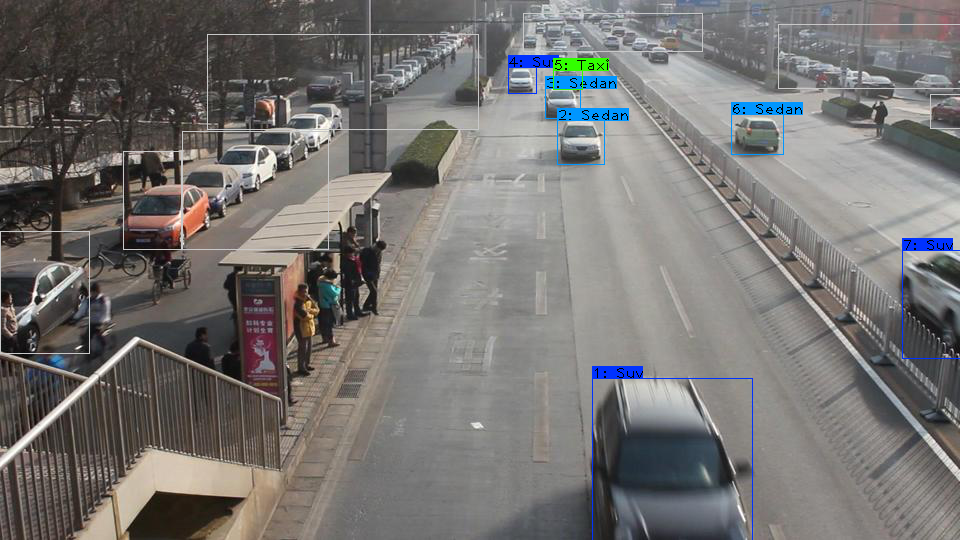

In [0]:
# Test dataloaders
next(iter(trainloader))
next(iter(testloader))

train_dataset.plot(0)

### 5. Create Model
Create Faster_RCNN model and loads the pretrained checkpoint from the drive

In [0]:
def load_model(checkpoint_file,model,optimizer):
    """
    Reloads a checkpoint, loading the model and optimizer state_dicts and 
    setting the start epoch
    """
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    return model,optimizer,epoch

In [0]:
try:
        torch.multiprocessing.set_start_method('spawn')    
except:
    pass

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.empty_cache()   

#%% Create Model
try:
    model
except:
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained_backbone = True,num_classes = 14)
"""
The input to the model is expected to be a list of tensors, 
each of shape [C, H, W], one for each image, and should be in 0-1 range. 
Different images can have different sizes.

During training, the model expects both the input tensors, 
as well as a targets (list of dictionary), containing:

-boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, 
    with values between 0 and H and 0 and W
-labels (Int64Tensor[N]): the class label for each ground-truth box
-The model returns a Dict[Tensor] during training, containing the 
    classification and regression losses for both the RPN and the R-CNN.

During inference, the model requires only the input tensors, and returns the
post-processed predictions as a List[Dict[Tensor]], one for each input image. 
The fields of the Dict are as follows:

-boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, 
    with values between 0 and H and 0 and W
-labels (Int64Tensor[N]): the predicted labels for each image
-scores (Tensor[N]): the scores or each prediction
"""

model = model.to(device)
checkpoint_file = "/content/drive/My Drive/Colab Notebooks/detrac_frcnn/Faster RCNN Checkpoints/best_faster_rcnn_detrac_4_1000.pt"
 
# if checkpoint specified, load model and optimizer weights from checkpoint
if checkpoint_file != None:
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Checkpoint loaded.")


Checkpoint loaded.


### 6. Test Model Inference


In [0]:
model.eval()

start = time.time()
X, Y = next(iter(trainloader))
elapsed = time.time() - start

start = time.time()    
X = X.to(device)
elapsed2 = time.time() - start

start = time.time()
out = model(X)
elapsed3 = time.time() - start

print("Dataloaders took {} sec".format(elapsed))
print("Transfer to GPU took {} sec".format(elapsed2))
print("Forward inference took {} sec".format(elapsed3))

Dataloaders took 1.313286304473877 sec
Transfer to GPU took 0.0055010318756103516 sec
Forward inference took 0.34081053733825684 sec


# Quantitative results plotting
Now that all necessary objects and functions are defined, view the results of the trained network inferencing by plotting them on the original images, along with the ground-truth labels.

Essentially, we need to take a batch, run it through, and plot both the original and the predicted labels. We'll write one function which takes the same style of label as input for both GT and predictions, and then outputs this

In [0]:
def plot_output(im,gt,pred):
  """
  Plots both ground-truth and predicted labels for the image
  """
  im = im.permute(0,2,3,1)[0]
  im = im.data.cpu().numpy()

  gtboxes = gt[0]['boxes'].data.numpy()
  gtlabels = gt[0]['labels'].data.numpy()

  predboxes = pred[0]['boxes'].data.cpu().numpy()
  predlabels = pred[0]['labels'].data.cpu().numpy()
  predconfs = pred[0]['scores'].data.cpu().numpy()

  #check type and convert PIL im to cv2 im if necessary
  assert type(im) in [np.ndarray, 
                      PIL.PngImagePlugin.PngImageFile,
                      PIL.JpegImagePlugin.JpegImageFile], "Invalid image format"
  im = pil_to_cv(im)
  cv_im = im.copy()*255

  class_colors = [
          (255,150,0),
          (255,100,0),
          (255,50,0),
          (0,255,150),
          (0,255,100),
          (0,255,50),
          (0,100,255),
          (0,50,255),
          (255,150,0),
          (255,100,0),
          (255,50,0),
          (0,255,150),
          (220,120,200)
          ]

  gt_color = (50,50,50)

  class_dict = {
        0:'Sedan',
        1:'Hatchback',
        2:'Suv',
        3:'Van',
        4:'Police',
        5:'Taxi',
        6:'Bus',
        7:'Truck-Box-Large',
        8:'MiniVan',
        9:'Truck-Box-Med',
        10:'Truck-Util',
        11:'Truck-Pickup',
        12:'Truck-Flatbed'
  }

  # iterate through all predictions
  for i in range(len(predlabels)):
      bbox =predboxes[i].astype(int)
      cls = predlabels[i].astype(int)
      conf = np.round(predconfs[i]*1000)/1000 
    
      cv2.rectangle(cv_im,(bbox[0],bbox[1]),(bbox[2],bbox[3]), class_colors[cls], 1)
      plot_text(cv_im,(bbox[0],bbox[1]),class_dict[cls],conf,class_colors,class_dict)

  #iterate through all ground truths
  for bbox in gtboxes:
    cv2.rectangle(cv_im,(bbox[0],bbox[1]),(bbox[2],bbox[3]), gt_color, 1)
  return cv_im


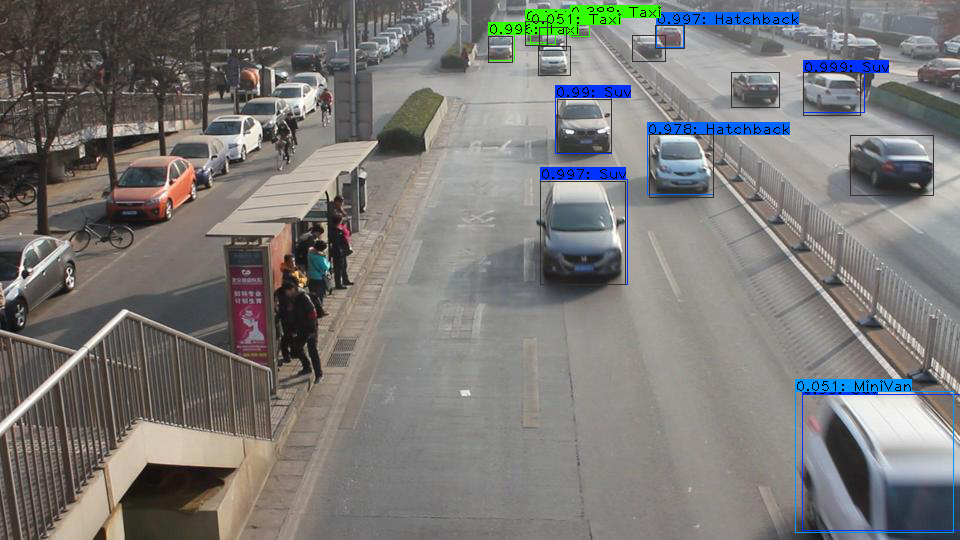

In [0]:
X, Y = next(iter(trainloader))   
X = X.to(device)
out = model(X)

cv_im = plot_output(X,Y,out)
cv2_imshow(cv_im)
